In [1]:
from tqdm import tqdm
%run model_evaluation
import torch
from torch import nn, optim
from sklearn.metrics import accuracy_score, confusion_matrix
from collections import defaultdict

import matplotlib.pyplot as plt
import proplot as pplt

# model, obs_rms, kwargs = load_model_and_env('nav_auxiliary_tasks/nav_aux_wall_1', 0)
# env = gym.make('NavEnv-v0', **kwargs)

save = 'plots/representation_learning/'

In [3]:
print_trained_models(ignore_non_pt=True)

ppo
├── nav_auxiliary_tasks
│   ├── EXP nav_c2_auxeuclid0: 5
│   ├── EXP nav_c2_auxeuclid1: 5
│   ├── EXP nav_c2_auxeuclid2: 5
│   ├── EXP nav_c2_auxwall1: 5
│   ├── EXP nav_c2_auxwall3: 5
│   ├── EXP nav_c4_auxeuclid0: 10
│   ├── EXP nav_c4_auxeuclid1: 10
│   ├── EXP nav_c4_auxeuclid2: 10
│   ├── EXP nav_c4_auxwall1: 5
│   ├── EXP nav_c4_auxwall3: 5
├── nav_invisible_shared
│   ├── EXP nav_c4_shared0.dist: 5
│   ├── EXP nav_c4_shared1.dist: 5
│   ├── EXP nav_c4_shared2.dist: 5
├── nav_invisible_wallcolors
│   ├── EXP nav_c1_dist: 3
│   ├── EXP nav_c2.5_dist: 5
│   ├── EXP nav_c2.5_none: 5
│   ├── EXP nav_c2_dist: 5
│   ├── EXP nav_c2_none: 5
│   ├── EXP nav_c4_dist: 5
│   ├── EXP nav_c4_none: 5
├── nav_poster
│   ├── EXP nav_pdistal_auxeuclid0: 5
│   ├── EXP nav_pdistal_auxeuclid1: 5
│   ├── EXP nav_pdistal_auxeuclid2: 5
│   ├── EXP nav_pdistal_auxwall1: 5
│   ├── EXP nav_pdistal_auxwall2: 5
│   ├── EXP nav_pproxim_auxeuclid0: 5
│   ├── EXP nav_pproxim_auxeuclid1: 5
│   ├── EXP nav_pp

In [2]:
WINDOW_SIZE = (300, 300)

def activation_testing(model, env, x, y, angle):
    """
    Pass a model and corresponding environment, x, y and angle, then 
    get the observation and perform a prediction with model to get activations
    
    returns:
        outputs object from model.base.forward
    
    outputs['activations'] is the activation dict
    note that outputs['activations']['shared_activations'] is the same as the 
        rnn hidden state output
    """
    vis_walls = env.vis_walls
    vis_wall_refs = env.vis_wall_refs
    
    env.character.pos = np.array([x, y])
    env.character.angle = angle
    env.character.update_rays(vis_walls, vis_wall_refs)
    
    obs = torch.tensor(env.get_observation(), dtype=torch.float32).view(1, -1)
    rnn_hxs = torch.zeros(1, model.recurrent_hidden_state_size, dtype=torch.float32)
    masks = torch.zeros(1, 1, dtype=torch.float32)
    
    outputs = model.base.forward(obs, rnn_hxs, masks, with_activations=True)
    outputs['obs'] = obs
    return outputs



def stack_activations(activation_dict):
    '''
    Activations passed back from a FlexBase forward() call can be appended, e.g.
    all_activations = []
    for ...:
        all_activations.append(actor_critic.act(..., with_activations=True)['activations'])
        
    This will result in a list of dictionaries
    
    This function converts all_activations constructed in this way into a dictionary,
    where each value of the dictionary is a tensor of shape
    [layer_num, seq_index, activation_size]
    '''
    stacked_activations = {}
    keys = activation_dict[0].keys()
    for key in keys:
        stacked_activations[key] = []
    
    for i in range(len(activation_dict)):
        for key in keys:
            num_layers = len(activation_dict[i][key])
            # activation: 1 x num_layers x activation_size
            activation = torch.vstack(activation_dict[i][key]).reshape(1, num_layers, -1)
            # stacked_activations: list (1 x num_layers x activation_size)
            stacked_activations[key].append(activation)
    
    for key in keys:
        activations = torch.vstack(stacked_activations[key]) # seq_len x num_layers x activation_size
        activations = activations.transpose(0, 1) # num_layers x seq_len x activation_size
        stacked_activations[key] = activations
    
    return stacked_activations



num_grid_slices = 5
num_grid_points = num_grid_slices**2

xs_grid = np.linspace(0, WINDOW_SIZE[0], num_grid_slices, endpoint=False)
ys_grid = np.linspace(0, WINDOW_SIZE[1], num_grid_slices, endpoint=False)

def find_grid_index(point=None, x=None, y=None):
    if point is not None:
        x = point[0]
        y = point[1]
    elif x is not None and y is not None:
        pass
    else:
        raise Exception('No valid argument combination given')
        
    x_grid_idx = np.max(np.argwhere(x >= xs_grid))
    y_grid_idx = np.max(np.argwhere(y >= ys_grid))
    total_grid_idx = x_grid_idx * num_grid_slices + y_grid_idx
    return total_grid_idx



def train_classifier(x, labels, valid_x=None, valid_labels=None, num_labels=None,
                     lr=0.1, epochs=1000, prog=False):
    '''
    Train an arbitrary classifier
        x (tensor): train X data
        labels (tensor): train labels
        valid_x (tensor, optional): train valid X data
        valid_labels (tensor, optional): train valid labels
        num_labels (int, optional): number of output labels
            for model to output. If not provided, default is
            given by the largest label value in labels
    '''
    if num_labels is None:
        num_labels = labels.max().item() + 1
    linear = nn.Linear(x.shape[1], num_labels)
    optimizer = optim.Adam(linear.parameters(), lr=lr)
    softmax = nn.Softmax(dim=1)
    # optimizer = optim.SGD(linear.parameters(), lr=0.1, momentum=0.9)
    criterion = nn.CrossEntropyLoss()
    losses = []
    accuracies = []
    valid_accuracies = []
    if prog:
        it = tqdm(range(epochs))
    else:
        it = range(epochs)
        
    for i in it:
        y = linear(x)
        loss = criterion(y, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        accuracies.append(accuracy_score(softmax(y.detach()).argmax(axis=1), labels))

        if valid_x is not None and valid_labels is not None:
            pred_valid = softmax(linear(valid_x)).argmax(axis=1)
            valid_accuracies.append(accuracy_score(pred_valid, valid_labels))
            
    return linear, losses, accuracies, valid_accuracies

# Train single MLP layer on non-episodic activations

Either take a grid of points and rotate angles about the points, then collect observations, or take randomly sampled points and angles. Then train a single layer MLP to detect where the agent is. This may be too challenging, so we may need to attempt to train a classifier to output where on a grid the agent is instead.

## Generate points (run before sections 1.2+)

Here we generate a set of training points for later sections to train with. Can either generate them by grid points or by generating a random set of points and angles

In [260]:
'''
Generate activations from the network - for a grid of points, rotate
around to get visual inputs to the system and get activations from trained model
'''

WINDOW_SIZE = (300, 300)
#Random points
num_points = 5000
rand_points = 280 * np.random.random((num_points, 2)) + 10
rand_angles = 2 * np.pi * np.random.random(num_points)

# outputs = activation_testing(model, env, 5, 5, 0)
all_activations = []            
all_obs = []

points = []
angles = []
pbar = tqdm()
with torch.no_grad():
    for i in range(num_points):
        x = rand_points[i, 0]
        y = rand_points[i, 1]
        angle = rand_angles[i]

        outputs = activation_testing(model, env, x, y, angle)
        all_activations.append(outputs['activations'])
        all_obs.append(outputs['obs'])

        pbar.update(1)
pbar.close()

stacked_activations = stack_activations(all_activations)
all_obs = torch.vstack(all_obs)



# Turn points into trainable data
points = np.array(rand_points)
angles = np.array(rand_angles)

scaled_points = np.zeros(points.shape)
scaled_points[:, 0] = points[:, 0]/np.max(points[:, 0])
scaled_points[:, 1] = points[:, 1]/np.max(points[:, 1])

scaled_angles = angles / np.max(angles)

scaled_points = torch.tensor(scaled_points, dtype=torch.float32)
scaled_angles = torch.tensor(scaled_angles, dtype=torch.float32)




0it [00:05, ?it/s]

118it [00:00, 1176.91it/s]
237it [00:00, 1182.78it/s]
357it [00:00, 1189.21it/s]
476it [00:00, 1182.65it/s]
597it [00:00, 1188.26it/s]
717it [00:00, 1188.87it/s]
836it [00:00, 1176.73it/s]
954it [00:00, 1165.75it/s]
1071it [00:00, 1166.12it/s]
1188it [00:01, 1159.28it/s]
1304it [00:01, 1151.60it/s]
1421it [00:01, 1156.21it/s]
1539it [00:01, 1162.43it/s]
1658it [00:01, 1169.78it/s]
1775it [00:01, 1161.94it/s]
1892it [00:01, 1134.68it/s]
2011it [00:01, 1150.03it/s]
2129it [00:01, 1157.98it/s]
2245it [00:01, 1150.84it/s]
2362it [00:02, 1155.61it/s]
2478it [00:02, 1156.02it/s]
2599it [00:02, 1171.18it/s]
2720it [00:02, 1181.83it/s]
2841it [00:02, 1189.31it/s]
2960it [00:02, 1188.58it/s]
3081it [00:02, 1194.05it/s]
3202it [00:02, 1197.88it/s]
3322it [00:02, 1197.58it/s]
3442it [00:02, 1197.36it/s]
3562it [00:03, 1197.21it/s]
3682it [00:03, 1184.67it/s]
3802it [00:03, 1188.30it/s]
3921it [00:03, 1187.89it/s]
4042it [00:03, 1193.56it/s]
4162it [00:03, 1190.98it/s]
4284it 

In [54]:
'''
Generate activations from the network - for a grid of points, rotate
around to get visual inputs to the system and get activations from trained model
'''

# Grid points
step_size = 10
xs = np.arange(0+step_size, WINDOW_SIZE[0], step_size)
ys = np.arange(0+step_size, WINDOW_SIZE[1], step_size)
thetas = np.linspace(0, 2*np.pi, 12, endpoint=False)

activations = activation_testing(model, env, 5, 5, 0)

activation_dict = {}

def append_activation_dict(activations, activation_dict):
    # Add keys to dict
    for key in activations:
        act = activations[key]
        if key not in activation_dict:
            activation_dict[key] = []
            if type(act) == list:
                for i in range(len(act)):
                    activation_dict[key].append([])
                
    # Append activation vectors to dict
    for key in activations:
        act = activations[key]
        if type(act) == list:
            for i in range(len(act)):
                activation_dict[key][i].append(act[i].squeeze())
        else:
            activation_dict[key].append(activations[key].squeeze())
            
    
points = []
angles = []
pbar = tqdm(total=len(xs)*len(ys)*len(angles))
activation_dict = {}
with torch.no_grad():
    for x in xs:
        for y in ys:
            for angle in thetas:
                points.append([x, y])
                angles.append(angle)

                activations = activation_testing(model, env, x, y, angle)
                append_activation_dict(activations, activation_dict)

                pbar.update(1)
pbar.close()

# Turn points into trainable data

points = np.array(points)
angles = np.array(angles)

scaled_points = np.zeros(points.shape)
scaled_points[:, 0] = points[:, 0]/np.max(points[:, 0])
scaled_points[:, 1] = points[:, 1]/np.max(points[:, 1])

scaled_angles = angles / np.max(angles)

scaled_points = torch.tensor(scaled_points, dtype=torch.float32)
scaled_angles = torch.tensor(scaled_angles, dtype=torch.float32)


0it [00:12, ?it/s]

117it [00:00, 1166.77it/s]
236it [00:00, 1178.71it/s]
354it [00:00, 1167.15it/s]
471it [00:00, 1167.14it/s]
588it [00:00, 1158.74it/s]
704it [00:00, 1158.14it/s]
820it [00:00, 1146.56it/s]
935it [00:00, 1146.70it/s]
1051it [00:00, 1149.89it/s]
1167it [00:01, 1148.53it/s]
1282it [00:01, 1148.06it/s]
1398it [00:01, 1150.76it/s]
1514it [00:01, 1145.71it/s]
1631it [00:01, 1152.08it/s]
1747it [00:01, 1150.10it/s]
1864it [00:01, 1155.09it/s]
1981it [00:01, 1158.69it/s]
2097it [00:01, 1154.71it/s]
2213it [00:01, 1148.51it/s]
2328it [00:02, 1148.06it/s]
2445it [00:02, 1153.70it/s]
2562it [00:02, 1157.66it/s]
2678it [00:02, 1157.45it/s]
2794it [00:02, 1153.85it/s]
2911it [00:02, 1157.71it/s]
3027it [00:02, 1154.09it/s]
3143it [00:02, 1154.95it/s]
3259it [00:02, 1152.10it/s]
3375it [00:02, 1153.56it/s]
3492it [00:03, 1157.56it/s]
3609it [00:03, 1160.37it/s]
3726it [00:03, 1158.86it/s]
3842it [00:03, 1158.30it/s]
3958it [00:03, 1157.90it/s]
4074it [00:03, 1157.62it/s]
4190it 

KeyboardInterrupt: 

## Train linear model for regression of position

This ends up being too difficult for both grid and randomly sampled points. Try instead grid method

In [72]:
'''
Train model on activations - try to find a single linear layer that
can map activation to position
'''

def train_linear_model(x, y, valid_x=None, valid_y=None, epochs=100):
    linear = nn.Linear(x.shape[1], y.shape[1])
    optimizer = optim.Adam(linear.parameters())
    mse_loss = nn.MSELoss()
    losses = []
    for i in range(100):
        y_pred = linear(x)
        optimizer.zero_grad()

        loss = mse_loss(y_pred, y)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
    if valid_x is not None and valid_y is not None:
        with torch.no_grad():
            pred = linear(valid_x) * 300
            mse = mse_loss(pred, valid_y)
            return linear, mse
    
    return linear

# Generate validation points
num_points = 100
rand_points = 280 * np.random.random((num_points, 2)) + 10
rand_angles = 2 * np.pi * np.random.random(num_points)
valid_activations = []
valid_obs = []
for i in range(num_points):
    x = rand_points[i, 0]
    y = rand_points[i, 1]
    angle = rand_angles[i]
    outputs = activation_testing(model, env, x, y, angle)
    valid_activations.append(outputs['activations'])
    valid_obs.append(outputs['obs'])

valid_activations = stack_activations(valid_activations)
valid_obs = torch.vstack(valid_obs)
valid_y = torch.tensor(rand_points, dtype=torch.float32)

results_dict = defaultdict(list)


for key in stacked_activations:
    num_layers = stacked_activations[key].shape[0]
    for i in range(num_layers):
        x = stacked_activations[key][i]
        linear, mse = train_linear_model(x, scaled_points, 
                            valid_x=valid_activations[key][i], valid_y=valid_y)
        results_dict[f'{key}_{i}'] = mse
    
    
# x = torch.vstack(activation_dict['actor_x'])
print(results_dict)

defaultdict(<class 'list'>, {'shared_activations_0': tensor(7086.9556), 'actor_activations_0': tensor(4925.1733), 'actor_activations_1': tensor(7587.1050), 'critic_activations_0': tensor(6282.2012), 'critic_activations_1': tensor(6219.3120)})


## Train classifier to output which grid of given granularity the agent might be in

In [261]:
grid_indexes = [find_grid_index(point) for point in points]
grid_indexes = torch.tensor(grid_indexes)


# Generate validation points
num_points = 100
rand_points = 280 * np.random.random((num_points, 2)) + 10
rand_angles = 2 * np.pi * np.random.random(num_points)
valid_activations = []
valid_obs = []
for i in range(num_points):
    x = rand_points[i, 0]
    y = rand_points[i, 1]
    angle = rand_angles[i]
    outputs = activation_testing(model, env, x, y, angle)
    valid_activations.append(outputs['activations'])
    valid_obs.append(outputs['obs'])

valid_activations = stack_activations(valid_activations)
valid_obs = torch.vstack(valid_obs)

valid_grid_indexes = [find_grid_index(point) for point in rand_points]
valid_grid_indexes = torch.tensor(valid_grid_indexes)



In [263]:
results_dict = {}

all_losses = []
all_accuracies = []
labels = []
all_valid_accuracies = []
epochs = 2000


for key in stacked_activations:
    print(key)
    num_layers = stacked_activations[key].shape[0]
    for i in range(num_layers):
        x = stacked_activations[key][i]
        linear, losses, accuracies, valid_accuracies = train_classifier(x, grid_indexes, 
                            valid_x=valid_activations[key][i], 
                            valid_labels=valid_grid_indexes, epochs=epochs)
        results_dict[f'{key}_{i}'] = linear
        labels.append(f'{key}_{i}')
        all_losses.append(losses)
        all_accuracies.append(accuracies)
        all_valid_accuracies.append(valid_accuracies)

        

# Train a classifier from observation alone
print('obs')
x = all_obs
linear, losses, accuracies, valid_accuracies = train_classifier(x, grid_indexes,
                                                valid_obs, valid_grid_indexes, epochs=epochs)
labels.append('obs')
results_dict['obs'] = linear
all_losses.append(losses)
all_accuracies.append(accuracies)
all_valid_accuracies.append(valid_accuracies)

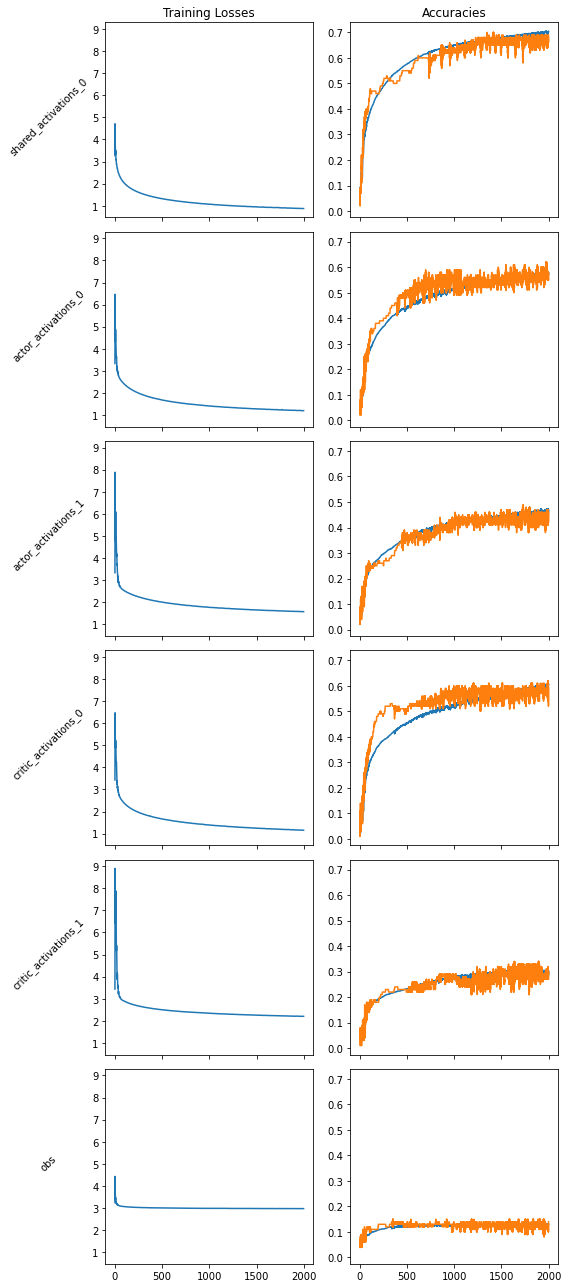

In [93]:
x = len(labels)
fig, ax = plt.subplots(x, 2, figsize=(8, x*3), sharey='col', sharex=True)
for i in range(x):
    ax[i, 0].plot(all_losses[i])
    ax[i, 1].plot(all_accuracies[i], label='Training Accuracy')
    ax[i, 1].plot(all_valid_accuracies[i], label='Valid Accuracy')
    ax[i, 0].set_ylabel(labels[i], rotation=45, labelpad=40)
    
ax[0, 0].set_title('Training Losses')
ax[0, 1].set_title('Accuracies')

plt.tight_layout()
plt.savefig(save+'1_3_classifier_training_curves.jpg', bbox_inches='tight')

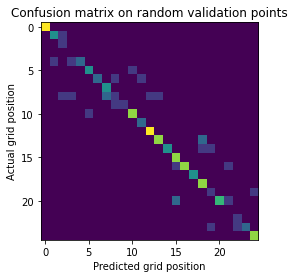

In [282]:
linear = results_dict['shared_activations_0']
y = linear(valid_activations['shared_activations'][0])
pred_labels = y.argmax(axis=1)

valid_grid_indexes

plt.imshow(confusion_matrix(pred_labels, valid_grid_indexes))
plt.title('Confusion matrix on random validation points')
plt.xlabel('Predicted grid position')
plt.ylabel('Actual grid position')
plt.savefig(save + '1_3_classifier_confusion_matrix', bbox_inches='tight')

# Train single MLP layer on episodic activations

## Running episodes starting at points on grid

Split grid into 9x9 (81 total starting points), facing away from center. Record positions and activations, train classifier to decode position from activations.

We note that using episodic activations has much more exploitable structure to perform decoding with, allowing for faster convergence of MLP and higher accuracies. It is likely that this follows the auxiliary task navigation paper, wherein the position of the agent can be decoded much more accurately as the episode progresses.

Next
* Need to create a validation methodology, since it is no longer accurate to just use random initial points for validation, actually need to follow a trajectory
* Would like to determine whether we can do this with a fixed trajectory i.e., actions that are not determined by the policy but either by random or determined by us. See if activations can still be decoded - this allows greater flexibility for testing

In [6]:
model, obs_rms, env = load_model_and_env('nav_auxiliary_tasks/nav_aux_wall_1', 
                                            0, env_name='NavEnv-v0')

In [254]:
WINDOW_SIZE = (300, 300)
step_size = 30
xs = np.arange(0+step_size, WINDOW_SIZE[0], step_size)
ys = np.arange(0+step_size, WINDOW_SIZE[1], step_size)
# thetas = np.linspace(0, 2*np.pi, 12, endpoint=False)
points = []
angles = []
for x in xs:
    for y in ys:
        point = np.array([x, y])
        
        # # Face the center
        # angle = np.arctan2(150 - x, 150 - y)
        
        #Face away from center
        angle = np.arctan2(x - 150, y - 150)
        
        points.append(point)
        angles.append(angle)

all_results = []
for i in tqdm(range(len(points))):
    point = points[i]
    angle = angles[i]
    kwargs['fixed_reset'] = [point, angle]
    results = evalu(model, obs_rms, n=1, env_kwargs=kwargs, with_activations=True,
                    data_callback=nav_data_callback)
    all_results.append(results)

100%|██████████████████████████████████████████████████████████████████████████████████| 81/81 [00:05<00:00, 14.23it/s]


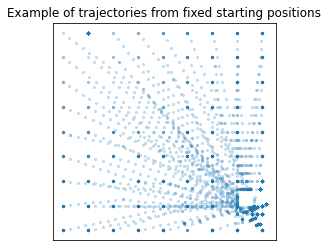

In [257]:
#stitch together positions and activations
pos = np.vstack([np.vstack(all_results[i]['data']['pos']) for i in range(len(all_results))])

all_activations = []
for i in range(len(all_results)):
    all_activations += all_results[i]['activations']
stacked = stack_activations(all_activations)

grid_indexes = torch.tensor([find_grid_index(p) for p in pos])

plt.figure(figsize=(4,4))
plt.scatter(pos.T[0], pos.T[1], alpha=0.2, s=5)
plt.xticks([])
plt.yticks([])
plt.title('Example of trajectories from fixed starting positions')
plt.savefig(save + '2_1_grid_start_trajectories', bbox_inches='tight')

In [35]:
results_dict = {}

all_losses = []
all_accuracies = []
labels = []
all_valid_accuracies = []
epochs = 1000


for key in stacked:
    print(key)
    num_layers = stacked[key].shape[0]
    for i in range(num_layers):
        x = stacked[key][i]
        linear, losses, accuracies, valid_accuracies = train_classifier(x, grid_indexes, 
                            valid_x=valid_activations[key][i], 
                            valid_grid_indexes=valid_grid_indexes, epochs=epochs)
        results_dict[f'{key}_{i}'] = linear
        labels.append(f'{key}_{i}')
        all_losses.append(losses)
        all_accuracies.append(accuracies)
        all_valid_accuracies.append(valid_accuracies)


shared_activations
actor_activations
critic_activations


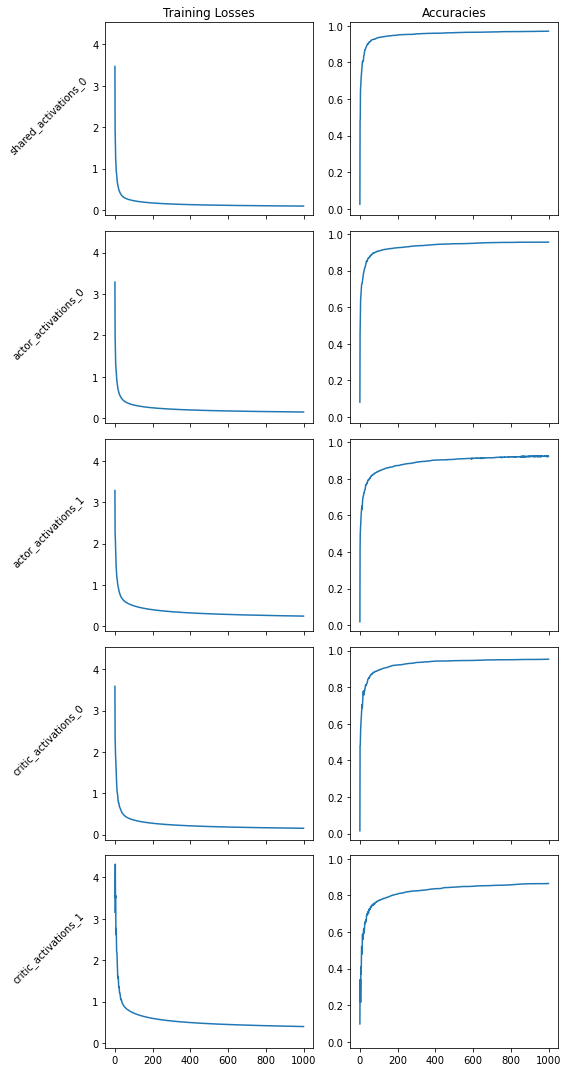

In [37]:
x = len(labels)
fig, ax = plt.subplots(x, 2, figsize=(8, x*3), sharey='col', sharex=True)
for i in range(x):
    ax[i, 0].plot(all_losses[i])
    ax[i, 1].plot(all_accuracies[i], label='Training Accuracy')
    # ax[i, 1].plot(all_valid_accuracies[i], label='Valid Accuracy')
    ax[i, 0].set_ylabel(labels[i], rotation=45, labelpad=40)
    
ax[0, 0].set_title('Training Losses')
ax[0, 1].set_title('Accuracies')

plt.tight_layout()
# plt.savefig('plots/representation_learning/1_3_classifier_training_curves.jpg', bbox_inches='tight')

## Testing forced action episodes

It appears we can very effectively perform the same grid classifier training on episodes that are run with random actions, so the actual actions taken don't seem to directly influence the activation trajectories (indirectly of course). This means that we can control an agent to move in certain trajectories and manipulate the sequence of observations seen to test specific representations learned

In [ ]:
model, obs_rms, kwargs = load_model_and_env('nav_auxiliary_tasks/nav_aux_wall_1', 0)

action_randomizer = lambda step: np.random.choice([0, 1, 2])
results = forced_action_evaluate(model, obs_rms, forced_actions=action_randomizer, env_kwargs=kwargs, 
                                data_callback=nav_data_callback, num_episodes=50, with_activations=True)

pos = np.vstack(results['data']['pos'])
angle = torch.tensor(np.vstack(results['data']['angle']))
stacked = stack_activations(results['activations'])
grid_indexes = torch.tensor([find_grid_index(p) for p in pos])

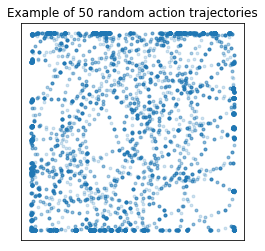

In [251]:
plt.figure(figsize=(4,4))
plt.xticks([])
plt.yticks([])
plt.scatter(pos.T[0], pos.T[1], alpha=0.2, s=8)
plt.title('Example of 50 random action trajectories')
plt.savefig(save + '2_2_forced_actions_random_trajectories', bbox_inches='tight')

In [85]:
# Train position decoder classifiers

results_dict = {}

all_losses = []
all_accuracies = []
labels = []
all_valid_accuracies = []
epochs = 300


for key in stacked:
    print(key)
    num_layers = stacked[key].shape[0]
    for i in range(num_layers):
        x = stacked[key][i]
        linear, losses, accuracies, valid_accuracies = train_classifier(x, grid_indexes, 
                                                                             epochs=epochs)
        results_dict[f'{key}_{i}'] = linear
        labels.append(f'{key}_{i}')
        all_losses.append(losses)
        all_accuracies.append(accuracies)
        all_valid_accuracies.append(valid_accuracies)

shared_activations
actor_activations
critic_activations


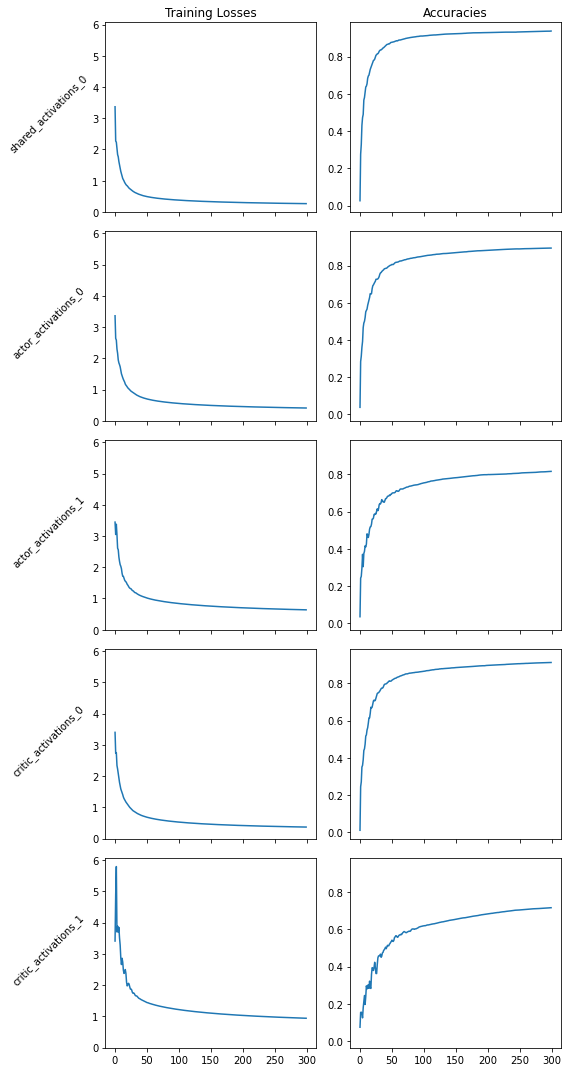

In [252]:
x = len(labels)
fig, ax = plt.subplots(x, 2, figsize=(8, x*3), sharey='col', sharex=True)
for i in range(x):
    ax[i, 0].plot(all_losses[i])
    ax[i, 1].plot(all_accuracies[i], label='Training Accuracy')
    # ax[i, 1].plot(all_valid_accuracies[i], label='Valid Accuracy')
    ax[i, 0].set_ylabel(labels[i], rotation=45, labelpad=40)
    
ax[0, 0].set_title('Training Losses')
ax[0, 1].set_title('Accuracies')

plt.tight_layout()
# plt.savefig('plots/representation_learning/1_3_classifier_training_curves.jpg', bbox_inches='tight')
plt.savefig(save + '2_2_pos_classifier_random_action', bbox_inches='tight')

### Testing to see how quickly in an episode agent position can be decoded accurately

In [139]:
action_randomizer = lambda step: np.random.choice([0, 1, 2])
one_ep = forced_action_evaluate(model, obs_rms, forced_actions=action_randomizer, env_kwargs=kwargs, 
                                data_callback=nav_data_callback, num_episodes=1, with_activations=True)


one_ep_pos = np.vstack(one_ep['data']['pos'])
one_ep_angle = np.vstack(one_ep['data']['angle'])
one_ep_stacked = stack_activations(one_ep['activations'])

#Use the trained classifier as grid-wise position decoder
with torch.no_grad():
    softmax = nn.Softmax(dim=1)
    y = results_dict['shared_activations_0'](one_ep_stacked['shared_activations'][0])
    probs = softmax(y)

In [238]:
def draw_character(pos, angle, size=10, ax=None):
    angle1 = angle - 0.3
    angle2 = angle + 0.3
    point1 = [pos[0], pos[1]]
    point2 = [pos[0] - np.cos(angle1)*size, pos[1] - np.sin(angle1)*size]
    point3 = [pos[0] - np.cos(angle2)*size, pos[1] - np.sin(angle2)*size]

    draw_color = np.array([0.9, 0.9, 0])

    poly = plt.Polygon([point1, point2, point3], fc=draw_color)
    if ax is None:
        plt.gca().add_patch(poly)
    else:
        ax.add_patch(poly)


C:\Users\14and\anaconda3\lib\site-packages\matplotlib\patches.py:1111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  xy = np.asarray(xy)


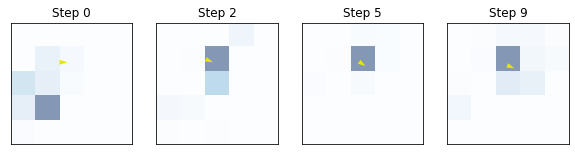

In [283]:
steps = [0, 2, 5, 9]
fig, ax = plt.subplots(1, 4, figsize=(10, 3), sharex=True, sharey=True)

for i, step in enumerate(steps):
    ax[i].imshow(probs[step].reshape(5,5).rot90(), cmap='Blues', alpha=0.5, extent=(0, 300, 0, 300))
    # plt.scatter(one_ep_pos.T[0, :step], one_ep_pos.T[1, :step], alpha=0.2)
    draw_character(one_ep_pos[step], one_ep_angle[step], 20, ax=ax[i])
    ax[i].set_title(f'Step {step}')
    ax[i].set_xticks([])
    ax[i].set_yticks([])

plt.savefig(save + '2_2_1_live_episode_decoding', bbox_inches='tight')
    


### Observing data distribution of activations

In [95]:
import umap
reducer = umap.UMAP()

embedding = reducer.fit_transform(stacked['shared_activations'][0])

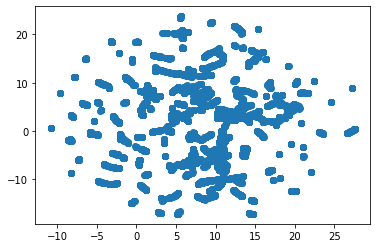

In [97]:
plt.scatter(embedding.T[0], embedding.T[1])

# Testing other representation classifiers

## Angle classifier

In [4]:
model, obs_rms, kwargs = load_model_and_env('nav_auxiliary_tasks/nav_aux_wall_1', 0)

action_randomizer = lambda step: np.random.choice([0, 1, 2])
results = forced_action_evaluate(model, obs_rms, forced_actions=action_randomizer, env_kwargs=kwargs, 
                                data_callback=nav_data_callback, num_episodes=50, with_activations=True)

pos = np.vstack(results['data']['pos'])
angle = torch.tensor(np.vstack(results['data']['angle']))
stacked = stack_activations(results['activations'])
grid_indexes = torch.tensor([find_grid_index(p) for p in pos])

In [7]:
angle_grid = np.linspace(-np.pi, np.pi, 12)

def categorize_angle(angle):
    angle_grid_idx = np.max(np.argwhere(angle >= angle_grid))
    return angle_grid_idx

angle_indexes = [categorize_angle(angle) for angle in results['data']['angle']]
angle_indexes = torch.tensor(angle_indexes)

all_losses = []
all_accuracies = []
labels = []

for key in stacked:
    num_layers = stacked[key].shape[0]
    for i in range(num_layers):
        x = stacked[key][i]
        linear, losses, acc, valid_acc = train_classifier(x, angle_indexes)
        all_losses.append(losses)
        all_accuracies.append(acc)
        labels.append(f'{key}_{i}')



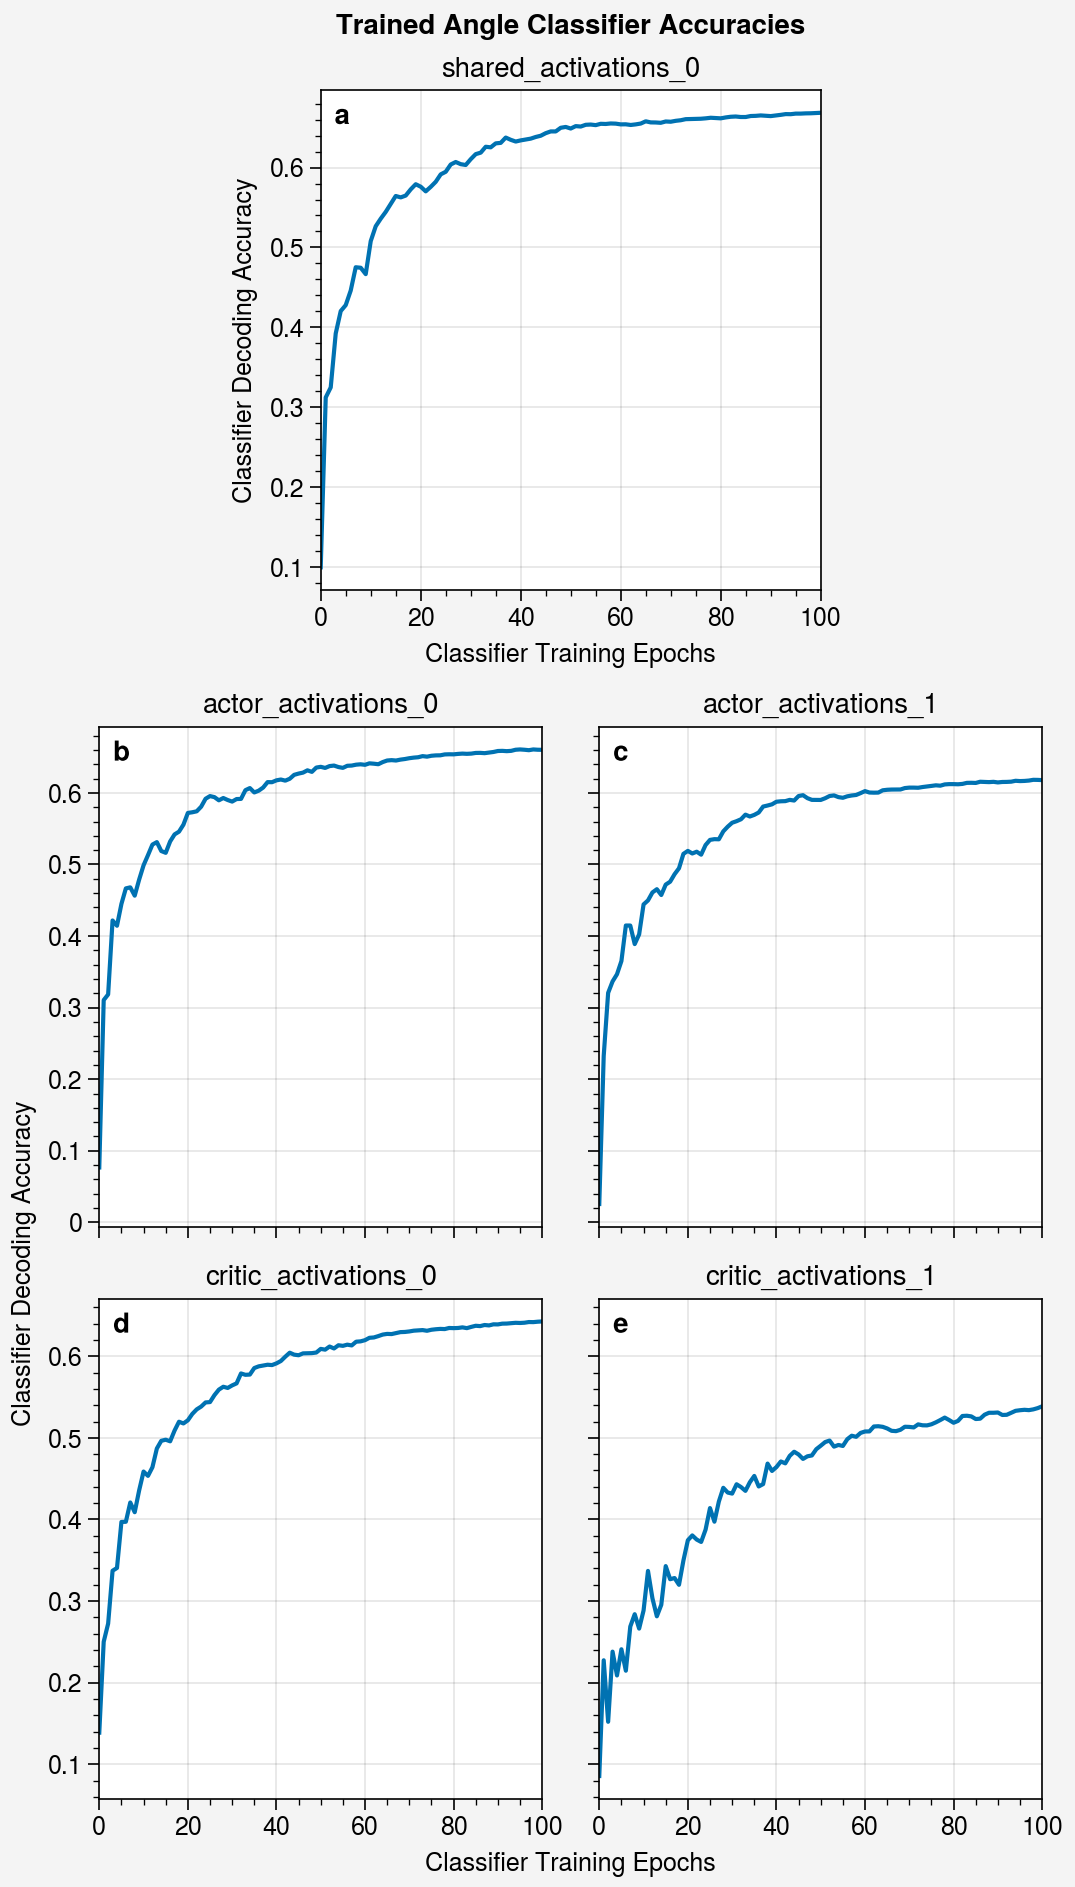

In [14]:
array = [
    [0, 1, 1, 0],
    [2, 2, 3, 3],
    [4, 4, 5, 5]
]
fig, ax = pplt.subplots(array)
ax.format(abc=True, abcloc='ul', 
          suptitle='Trained Angle Classifier Accuracies',
         xlim=(0, 100),
         xlabel='Classifier Training Epochs',
         ylabel='Classifier Decoding Accuracy',
         title=labels)
for i in range(5):
    ax[i].plot(all_accuracies[i])
    
fig.save(save + '3_1_angle_classifier_accuracies.png')

# Comparing different models interpretability levels

In [ ]:
c4_aux_models = ['nav_auxiliary_tasks/nav_c4_auxwall1', #Report proximal wall
          'nav_auxiliary_tasks/nav_c4_auxwall3', #Report distal wall
          'nav_auxiliary_tasks/nav_c4_auxeuclid2', #Report euclidean distance
          'nav_auxiliary_tasks/nav_c4_auxeuclid1', #Report constant 0
          'nav_auxiliary_tasks/nav_c4_auxeuclid0', #Basic 4 color no task
         ]
c2_aux_models = ['nav_auxiliary_tasks/nav_c2_auxwall1', #Report proximal wall
          'nav_auxiliary_tasks/nav_c2_auxwall3', #Report distal wall
          'nav_auxiliary_tasks/nav_c2_auxeuclid2', #Report euclidean distance
          'nav_auxiliary_tasks/nav_c2_auxeuclid1', #Report constant 0
          'nav_auxiliary_tasks/nav_c2_auxeuclid0', #Basic 4 color no task
         ]
shared_layers = [
]

In [2]:
%%time
model, obs_rms, kwargs = load_model_and_env('nav_auxiliary_tasks/nav_c4_auxwall1', 0)

action_randomizer = lambda step: np.random.choice([0, 1, 2])
results = forced_action_evaluate(model, obs_rms, forced_actions=action_randomizer, env_kwargs=kwargs, 
                                data_callback=nav_data_callback, num_episodes=1, with_activations=True)


CPU times: total: 250 ms
Wall time: 250 ms


In [4]:
obs, rnn_hxs, masks = results['obs'][0], results['hidden_states'][0], results['masks'][0]

import sys
sys.path.append('../')
from a2c_ppo_acktr.model import Policy

In [7]:
env = gym.make('NavEnv-v0', **kwargs)

# model = Policy(obs.squeeze().shape, env.action_space, base='FlexBase', base_kwargs={'num_shared_layers': 0, 'auxiliary_heads': [[-1, 0, 1]]})
model = Policy(obs.squeeze().shape, env.action_space, base='FlexBase', base_kwargs={'num_shared_layers': 0})

model

Policy(
  (base): FlexBase(
    (gru): GRU(60, 64)
    (critic0): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): Tanh()
    )
    (actor0): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): Tanh()
    )
    (critic1): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): Tanh()
    )
    (actor1): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): Tanh()
    )
    (critic_head): Linear(in_features=64, out_features=1, bias=True)
  )
  (dist): Categorical(
    (linear): Linear(in_features=64, out_features=4, bias=True)
  )
)

In [8]:
model.base(obs, rnn_hxs, masks)

{'value': tensor([[0.2104]], grad_fn=<AddmmBackward0>),
 'actor_features': tensor([[ 0.5101, -0.0373,  0.9042, -0.3687, -0.5381,  0.5913,  0.6779,  0.2915,
          -0.7384,  0.6311, -0.7058,  0.1975,  0.1848, -0.0258,  0.6267, -0.4563,
          -0.9090, -0.2286, -0.3865,  0.6364, -0.6111,  0.3810,  0.6191,  0.5605,
           0.5568,  0.2894, -0.8087, -0.4375, -0.0384, -0.2637, -0.8234,  0.3354,
           0.3833, -0.0249, -0.3595, -0.4352, -0.2236, -0.0648,  0.4241,  0.7400,
          -0.6752, -0.9119, -0.2102, -0.4283, -0.1004, -0.5272, -0.1790,  0.4617,
          -0.0795,  0.7539, -0.5169,  0.6025,  0.4133, -0.6048,  0.7742,  0.3636,
           0.5032,  0.2955,  0.0916,  0.2133,  0.2273, -0.4979, -0.8319,  0.1665]],
        grad_fn=<TanhBackward0>),
 'rnn_hxs': tensor([[ 0.7085, -0.2607, -0.5744, -0.7895, -0.2906,  0.0522, -0.1475, -0.6198,
           0.2835,  0.4206,  0.3897, -0.2475, -0.1570, -0.1218,  0.6143,  0.2878,
          -0.2923,  0.0663,  0.7505, -0.1964,  0.7742, -0.5

In [9]:
# model, obs_rms, kwargs = load_model_and_env('nav_invisible_shared/nav_c4_shared0.dist', 0)
action_randomizer = lambda step: np.random.choice([0, 1, 2])
results = forced_action_evaluate(model, obs_rms, forced_actions=action_randomizer, env_kwargs=kwargs, 
                                data_callback=nav_data_callback, num_episodes=1, with_activations=True)


In [60]:
def train_position_classifier(model, model_num=0, epochs=100, train_episodes=100, 
                             valid_episodes=10, seed=None):
    model, obs_rms, kwargs = load_model_and_env(model, model_num)
    
    # Generate random episodes to train on
    if seed is not None:
        np.random.seed(0)
    action_randomizer = lambda step: np.random.choice([0, 1, 2])
    results = forced_action_evaluate(model, obs_rms, forced_actions=action_randomizer, env_kwargs=kwargs, 
                                    data_callback=nav_data_callback, num_episodes=train_episodes, with_activations=True)
    
    pos = np.vstack(results['data']['pos'])
    angle = torch.tensor(np.vstack(results['data']['angle']))
    stacked = stack_activations(results['activations'])
    grid_indexes = torch.tensor([find_grid_index(p) for p in pos])
    
    
    # Test validaation on a few more random episodes
    results = forced_action_evaluate(model, obs_rms, forced_actions=action_randomizer, env_kwargs=kwargs, 
                                    data_callback=nav_data_callback, num_episodes=valid_episodes, with_activations=True)
    valid_pos = np.vstack(results['data']['pos'])
    valid_angle = torch.tensor(np.vstack(results['data']['angle']))
    valid_stacked = stack_activations(results['activations'])
    valid_grid_indexes = torch.tensor([find_grid_index(p) for p in valid_pos])
    

    
    # Train position decoders on activations
    classifiers = {}

    all_losses = []
    all_accuracies = []
    labels = []
    valid_accuracies = []

    for key in stacked:
        # print(key)
        num_layers = stacked[key].shape[0]
        for i in range(num_layers):
            x = stacked[key][i]
            valid_x = valid_stacked[key][i]
            
            linear, losses, accuracies, valid_accuracies = train_classifier(x, grid_indexes, 
                                                                                 epochs=epochs)
            classifiers[f'{key}_{i}'] = linear
            labels.append(f'{key}_{i}')
            all_losses.append(losses)
            all_accuracies.append(accuracies)
    
            pred_valid = linear(valid_x).argmax(axis=1)
            valid_accuracies.append(accuracy_score(pred_valid, valid_grid_indexes))
            
    return {
        'labels': labels,
        'losses': all_losses,
        'training_acc': all_accuracies,
        'final_valid_acc': valid_accuracies,
        'classifiers': classifiers
    }


    
    

In [61]:
results = train_position_classifier('nav_auxiliary_tasks/nav_c4_auxwall1',
                                   train_episodes=30)

In [64]:
results['labels']

['shared_activations_0',
 'actor_activations_0',
 'actor_activations_1',
 'critic_activations_0',
 'critic_activations_1']

In [63]:
results['final_valid_acc']

[0.7316326530612245]